In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, History

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


In [2]:
def prepare_training_data(df_F, df_D, df_Dt, d):
    
    DF = []
    for i in range(d):
        if i == 0:
            DF = np.concatenate((df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis = 1)
        else:
            DF = np.concatenate((DF, df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis=1)

    DF = DF[d:,:]
    Dy = np.concatenate((df_D.values, df_Dt.values), axis=1)
    Dy = Dy[d:,:]
    
    return DF, Dy

In [3]:
def train_test_split(DF, Dy, d, x_scaler, y_scaler):

    dim = np.shape(Dy)

    n_nodes = int(dim[1]/2)
    n_y = dim[1]
    x = np.linspace(0,1, n_nodes)

    #Scaling
    DFscaled = x_scaler.transform(DF)
    Dyscaled = y_scaler.transform(Dy)

    X_train = DFscaled
    Y_train = Dyscaled

    #Train test split
    train_portion = 0.8
    n_timesteps = len(X_train[:,0])
    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]

    n_features = int(x_train.shape[1]/d)
    
    #Reshape training data into 3D array as required by the LSTM layer
    #Input shape is: (n_timesteps, d, n_features)
    x_train = x_train.reshape((x_train.shape[0], d, n_features))
    x_test = x_test.reshape((x_test.shape[0], d, n_features))

    return x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x

In [4]:
def initialize_model(n_units, x_train, y_train, lr, n_layers):
    model = Sequential()
    
    #Add hidden layers, return_sequences=True if next layer is LSTM, False otherwise
    if n_layers == 1:
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
        
    elif n_layers == 2:
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        model.add(LSTM(n_units))
    else: 
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        for layer in range(n_layers-1):
            model.add(LSTM(n_units, return_sequences = True))
        model.add(LSTM(n_units))
    
    
    #model.add(Dropout(0.1))
    
    model.add(Dense(len(y_train[0,:]))) #Output Layer
    adam = Adam(lr=lr)
    model.compile(loss='mae', optimizer=adam)
    
    #Define callbacks
    history = History()
    earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')
    callback_list = [earlystop, history]
    return model, callback_list

In [5]:
def get_error(predictions, y_test):
    #Squared error is integrated numerically in space for each timestep and summed
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [6]:
def independent_predictions(x_test):

    input_i = np.copy(x_test[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known

    for i in range(future_timesteps): 
        pred = model.predict(input_i_reshaped) #Predict next timestep
        preds[i, :] = pred[0] 

        input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
        input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
        input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

        input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
        
    return preds

In [7]:
def get_scalers(DF, Dy):
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit_transform(DF)
    y_scaler.fit_transform(Dy)
    
    return x_scaler, y_scaler

In [12]:
def get_batch_scalers(n_batches, training_set):
    
    #Simple version
    for i in range(n_batches):
        
        df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(i+1) + '.csv')
        df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(i+1) + '.csv')
        df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(i+1) + '.csv')
        
        if i == 0:  
            x_range = df_D.values.max() - df_D.values.min()
            imax = i
        
        else:
            new_x_range = df_D.values.max() - df_D.values.min()
            
            if new_x_range > x_range:
                x_range = new_x_range
                imax = i
                
    df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(imax+1) + '.csv')
    df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(imax+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(imax+1) + '.csv')
    
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    return x_scaler, y_scaler

In [194]:
#columns = ['training set', 'n_layers', 'height', 'epochs', 'batch size', 'learning rate', 'early stopping', 'stop loss', 'Training Error', 'Test Error',
#           'Ind test error', 'Ind train error', 'Training time', 'Total time']
#df = pd.DataFrame(columns = columns)

#df.to_csv('../results/RNN_velocity_results.csv')

In [16]:
######################### BATCH TRAINING ########################################

n_batches = 1
d = 10 

t0 = time.time()

#Select training set
training_set = ''

x_scaler, y_scaler = get_batch_scalers(n_batches, training_set) #Get global scalers

#Hyperparameter settings
epochs = 100
layers = 1
height = 100
batch_size = 1000
lr = 0.0005



for iteration in range(n_batches):
    
    #Import training data
    df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(iteration+1) + '.csv')

    #Prepare training data
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #Split into train and test set
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    
    #Initialize model
    #if iteration == 0:
    #    model, callback_list = initialize_model(height, x_train, y_train, lr, layers)
    
    #Train model
    #hist = model.fit(x_train, y_train, epochs=epochs, callbacks=callback_list, batch_size=batch_size, verbose=1, shuffle=False)
    #model.fit(x_train, y_train, epochs=100, callbacks=None, batch_size=1000, verbose=1, shuffle=False)
    
    training_time = time.time() - ts
    
    #Evaluate model both dependent and independent training and test errors
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    pred_ind_all_train = independent_predictions(x_train)
    pred_ind_train = pred_ind_all_train[:, 0:n_nodes]
    pred_ind_u_train = y_scaler.inverse_transform(pred_ind_all_train)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    ind_train_error = get_error(pred_ind_train, y_train[0:len(pred_ind_train[:,0]),0:n_nodes])
    total_time = time.time() - t0
    
    #Print results
    info = {'Iteration number': iteration+1, 'Training Error': training_error, 'Test Error': test_error, 'Ind test error': ind_error,
            'Ind train error': ind_train_error, 'Training time': training_time, 'Total time': total_time}
    print(info)
    
    #Write results in results table
    df = pd.read_csv('../results/RNN_velocity_results.csv', index_col=0)
    
    df = df.append({'training set': training_set, 'n_layers': layers, 'height': height, 'epochs': epochs, 'batch size': batch_size, 
                    'learning rate': lr,
                    'early stopping': len(hist.history['loss']), 'stop loss': hist.history['loss'][-1], 'Training Error': training_error,
                    'Test Error': test_error, 'Ind test error': ind_error, 'Ind train error': ind_train_error,
                    'Training time': training_time, 'Total time': total_time}, ignore_index = True)
    
    df.to_csv('../results/RNN_velocity_results.csv')

{'Iteration number': 1, 'Training Error': 0.076715776925834478, 'Test Error': 0.015867943746427297, 'Ind test error': 1.3170955916614577, 'Ind train error': 8.7837255490956228, 'Training time': 0.0, 'Total time': 88.39849376678467}


NameError: name 'hist' is not defined

In [232]:
#df = df.drop(columns=df.columns[0])
#df.to_csv('../results/RNN_velocity_results.csv')

In [238]:
#pd.read_csv('../results/RNN_velocity_results.csv', index_col=0)
df

,training set,n_layers,height,epochs,batch size,learning rate,early stopping,stop loss,Training Error,Test Error,Ind test error,Ind train error,Training time,Total time
0,rr,2,100,500,1000,0.0005,115,0.005931,0.428430,0.102271,4.126604,19.038270,2173.341693,2263.469776
1,rr,2,100,500,1000,0.0001,36,0.005536,0.457434,0.111018,18.604378,96.249718,707.928417,803.638126
2,rr,3,50,500,1000,0.0005,160,0.013542,0.497549,0.108562,11.480535,70.656266,5234.750504,5392.588225
3,rr,3,100,500,1000,0.0005,278,0.004497,1.093541,0.246645,16.985114,97.339143,12917.886360,13195.994140


In [13]:
#save best model
#trained on= gr_set1

#model.save('../models/RNN_gr_set1.h5')

#### CONTINUE TRAINING ####
#model = load_model('../models/RNN_gr_set1.h5')

#model.fit(x_train, y_train, epochs=100, verbose=1)

#model.save('beam_model.h5')

#del(model)

In [239]:
def new_independent_predictions(x_test):

    input_i = np.copy(x_test[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known

    for i in range(future_timesteps): 
        pred = new_model.predict_on_batch(input_i_reshaped) #Predict next timestep
        preds[i, :] = pred[0] 

        input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
        input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
        input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

        input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
        
    return preds

In [253]:
new_model = Sequential()
new_model.add(LSTM(100, batch_input_shape=(1, d, n_features), stateful = True))
new_model.add(Dense(len(y_train[0,:])))

new_model.set_weights(model.get_weights())

training_time = time.time() - ts

#Evaluate model both dependent and independent training and test errors

#pred_ind_all_train = new_independent_predictions(x_train)
pred_ind_all = new_independent_predictions(x_test)
pred_ind = pred_ind_all[:, 0:n_nodes]
#pred_ind_train = pred_ind_all_train[:, 0:n_nodes]

In [254]:
ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
print(ind_error)
ind_train_error = get_error(pred_ind_train, y_train[0:len(pred_ind_train[:,0]),0:n_nodes])
print(ind_train_error)

501.795588676
2011.72914752


In [259]:
#pred_test_all = independent_predictions(x_test)
#pred_test = pred_test_all[:, 0:n_nodes]
get_error(pred_test, y_test[0:len(pred_test[:,0]),0:n_nodes])

7.6955245707747464

In [260]:
new_model = Sequential()
new_model.add(LSTM(100, batch_input_shape=(1, d, n_features), stateful = False))
new_model.add(Dense(len(y_train[0,:])))

new_model.set_weights(model.get_weights())

pred_ind_all = new_independent_predictions(x_test)
pred_ind = pred_ind_all[:, 0:n_nodes]

ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
print(ind_error)

7.69552457077


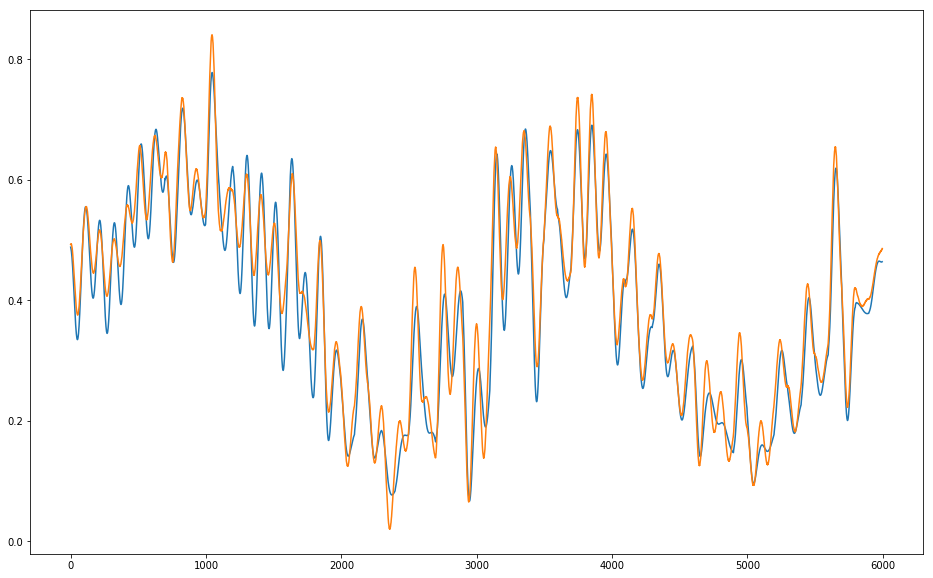

In [258]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
#plt.plot(pred_ind[:,n_nodes-1])
plt.plot(pred_test[:,n_nodes-1])
plt.plot(y_test[:, n_nodes-1])
plt.show()

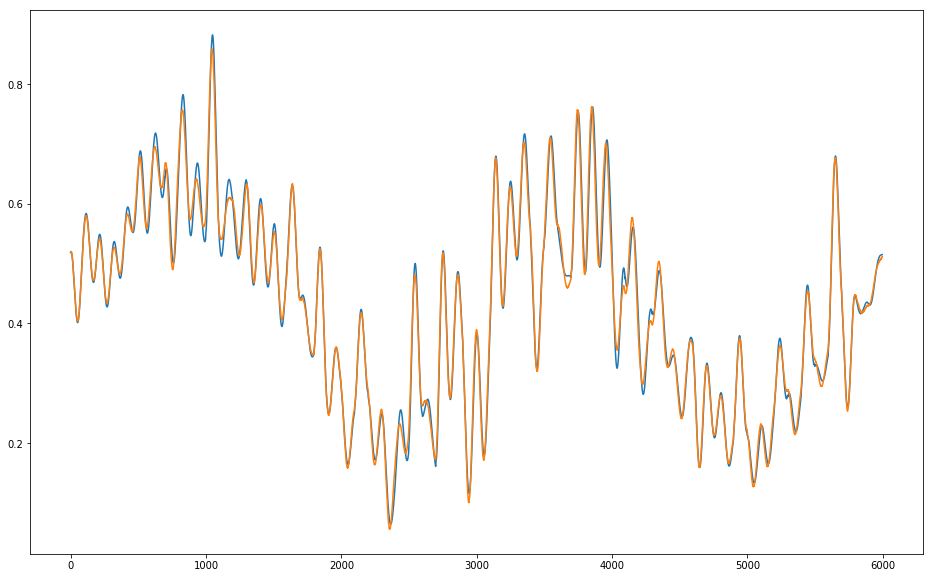

{'Iteration number': 1, 'Training Error': 0.076715776925834478, 'Test Error': 0.015867943746427297, 'Ind test error': 1.3170955916614577, 'Training time': 0.0, 'Total time': 12.344907760620117}


In [18]:
######################### BATCH TESTING ########################################

n_batches = 1
d = 10

t0 = time.time()
for iteration in range(n_batches):

    df_D = pd.read_csv('../training_batches/D' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/F' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/Dt' + str(iteration+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    #if i == 0:
    #    model, callback_list = initialize_model(100, x_train, y_train)
    
    #model.fit(x_train, y_train, epochs=100, callbacks=callback_list, batch_size=len(x_train), verbose=0, shuffle=False)
    
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    #plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()

    
    total_time = time.time() - t0
    
    info = {'Iteration number': iteration+1, 'Training Error': training_error, 'Test Error': test_error, 'Ind test error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

In [19]:
#Export results
np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [203]:
pred_ind_all = independent_predictions(x_train)
pred_ind = pred_ind_all[:, 0:n_nodes]

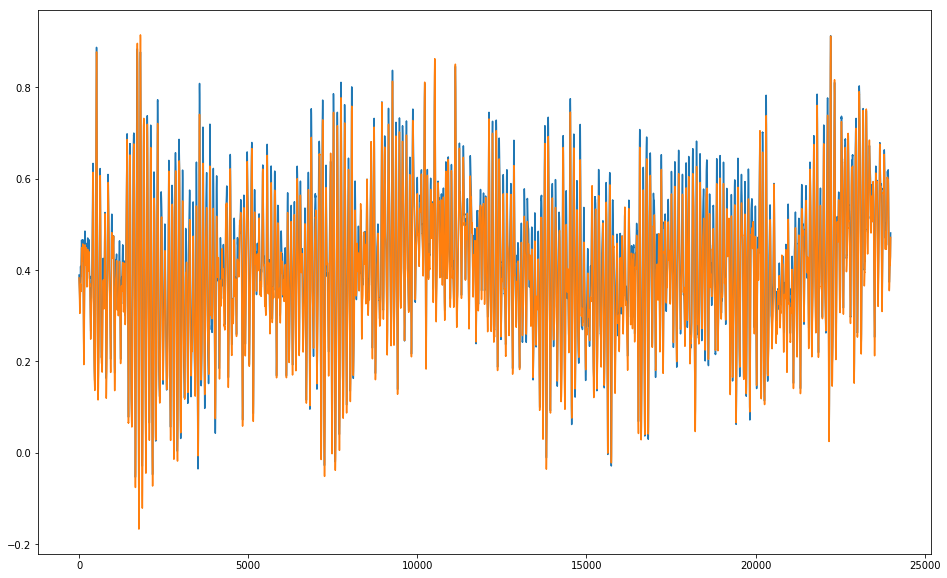

In [204]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_train[:, n_nodes-1])
plt.show()

In [89]:
DF.shape

(4995, 205)

In [91]:
df_D.values.shape

(5000, 21)

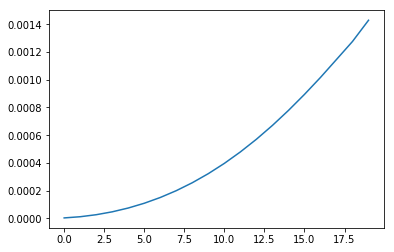

In [20]:
plt.plot(y_test_u[50,:])